# 05 SHAP Explainability

Compute SHAP values for the surrogate model if SHAP is available.


Saved SHAP summary to /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/exp01_reports/figures/shap_summary.png


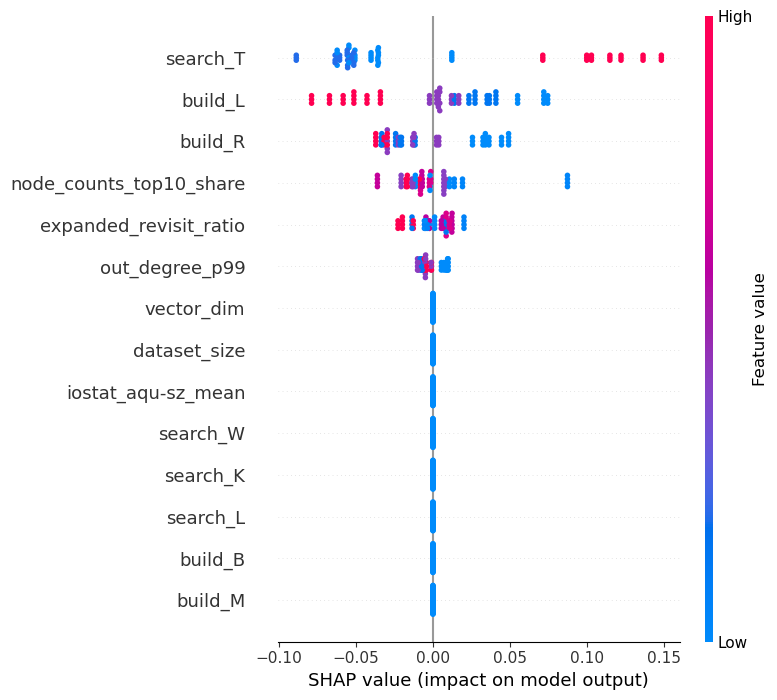

In [1]:
import os
import numpy as np
from pathlib import Path
import pandas as pd

ANALYZE_DIR = Path('../outputFiles/analyze').resolve()
REPORT_PREFIX = os.environ.get('REPORT_PREFIX', 'analysis_reports')
REPORT_DIR = (Path('../outputFiles/analyze').resolve() / REPORT_PREFIX)
stats_path = sorted(ANALYZE_DIR.glob('collected_stats_*.csv'))[-1]
df = pd.read_csv(stats_path)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['latency_p99_us'])
df['log_latency_p99'] = np.log(df['latency_p99_us'].clip(lower=1))

features = [
    'build_R','build_L','build_B','build_M',
    'search_K','search_L','search_W','search_T',
    'vector_dim','dataset_size',
    'out_degree_p99','expanded_revisit_ratio','node_counts_top10_share',
    'iostat_aqu-sz_mean',
]
features = [f for f in features if f in df.columns]

X = df[features]
y = df['log_latency_p99']

try:
    import xgboost as xgb
    import shap
    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    out = (REPORT_DIR / 'figures')
    out.mkdir(parents=True, exist_ok=True)
    import matplotlib.pyplot as plt
    plt.tight_layout()
    plt.savefig(out / 'shap_summary.png', dpi=150)
    print('Saved SHAP summary to', out / 'shap_summary.png')
except Exception as e:
    print('SHAP or xgboost not available:', e)
